## Введение
Данный эксперимент посвящен анализу производительности различных алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными ограничениями.

Исследуется производительность следующих алгоритмов:
1. Алгоритм Хеллингса. Грамматика должна находится в ОНФХ. Для каждого не терминала необходимо хранить из какой вершины
в какую можно "прийти". И на каждой итерации путем "склеивания" не терминалов проверяется есть ли такая продукция в грамматике, если да, то сохраняется не терминал с соответствующими вершинами, из которого выводится данная "склеенная" продукция.
2. Матричный алгоритм. Грамматика должна находится в ОНФХ. Строится матрица смежности графа и производится суммирование матрицы с ее квадратом, пока матрица изменяется.
3. Тензорный алгоритм. По КС грамматике строится рекурсивный автомат, для графа и автомата строятся матрицы смежности, далее пока результат изменяется, производиться пересечение матриц и транзитивное замыкание полученного пересечения, затем добавляем в граф ребра для вершин, для которых были найдены пути.

## Цель
Необходимо сравнить работу алгоритмов и ответить на поставленные вопросы:

- Какой из трёх указанных алгоритмов обладает лучшей производительностью?
- Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

## Наборы данных
Выбор данных обусловлен тем, что хотелось рассмотреть поведение алгоритмов на графах различных размеров. Работа алгоритмов проверяется на следующих графах:

#### Анализ RDF
На графах больших по числу узлов и ребер, чем [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core), работа алгоритмов занимала слишком много времени.
1. [atom](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/atom.html#atom)
2. [pizza](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/pizza.html#pizza)
3. [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core)

#### Анализ указателей в C
1. [wc](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/wc.html#wc)
2. [bzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/bzip.html#bzip)
3. [gzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/gzip.html#gzip)

#### Анализ Java-программ
1. [lusearch](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/lusearch.html#lusearch)

#### КС запросы
Запросы были взяты из классических грамматик для соответствующих групп графов в наборе:
- Для RDF графов:
    ```
    S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
    ```
- Для C графов:
    ```
    S -> d_r V d
    V -> V1 V2 V3
    V1 -> epsilon
    V1 -> V2 a_r V1
    V2 -> epsilon
    V2 -> S
    V3 -> epsilon
    V3 -> a V2 V3
    ```

#### Регулярные запросы
Для генерации регулярных выражений используются 4 самые распространенные метки на ребрах графа и строятся по следующему шаблону, где l1, l2, l3, l4 метки ребер:

   1.       (l1 | l2)* l3
   2.       (l3 | l4)+ l1*
   3.       l1 l2 l3 (l4|l1)*

## Описание эксперимента

#### Технические характеристики машины:
- Процессор: core i7-10750H 2.60GHz, 6 ядер, 12 логических процессоров.
- Кэш: 1ого уровня - 384 Кб, 2ого уровня 1,5 Мб, 3его уровня 12 Мб.
- Объем оперативной памяти: 16гб, 2933 МГц.
- ОС: Windows 10.
- Версия Python: 3.9.6

#### Проведение замеров:
Замеры времени производятся в секундах при помощи библиотеки [time](https://docs.python.org/3/library/time.html). Замеряется время работы функций из файла cfpq. На каждый вариант набора данных производится 10 запусков, вычисляется среднее арифметическое и стандартное отклонение значений времени и выводятся все замеры в виде диаграмм.



**Импортируем необходимые библиотеки и инициализируем глобальные переменные для эксперимента**


In [ ]:
import time
from collections import Counter

import cfpq_data
from pyformlang.regular_expression import Regex
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from project.rpq import rpq_by_tensor

from project.cfpq import *

cfpq_data.logging.disable()

NUMBER_OF_LAUNCHES = 10
TYPE_OF_ALG_CFPQ = ["matrix", "tensor", "hellings"]
COMPARE_ALG_CFPQ_RPQ = ["matrix", "tensor", "tensor_rpq"]
RDF_DATASET_GRAPH = ["atom", "pizza", "core"]
C_DATASET_GRAPH = ["wc", "bzip", "gzip"]
JAVA_DATASET_GRAPH = ["lusearch"]
TYPE_OF_REGEXES = ["(l1 | l2)* l3",
                   "(l3 | l4)+ l1*",
                   "l1 l2 l3 (l4|l1)*"]

CFG_RDF = [
    CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type"
    )
]

CFG_C = [
    CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
]

**Функция для отрисовки диаграммы**

In [36]:
def draw_diagram(graphs, algos_time, algos_deviation, type_algos, query=""):
    index = np.arange(len(graphs))
    bw = 0.2
    plt.title(query, fontsize=15)
    colors = ["r", "b", "g", "y"]
    for count, name_algos in enumerate(type_algos):
        plt.bar(index + bw * (count + 1), algos_time[name_algos], bw,
                yerr=algos_deviation[name_algos],
                error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[count], label=name_algos)
    plt.xlabel('Graphs')
    plt.ylabel('Time, seconds')
    plt.xticks(index + 1 * bw, graphs)
    plt.yscale('log')
    plt.legend(loc=1)
    plt.show()

**Функция для генерации регулярных выражений по графу**

In [37]:
def generate_regexes(graph, num_of_type):
    most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
    if num_of_type == 0:
        return "(" + str(most_common_labels[0][0]) + "|" + str(most_common_labels[1][0]) + ")*" + str(
            most_common_labels[2][0])
    elif num_of_type == 1:
        return "(" + str(most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")|(" + str(
            most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")*" + str(
            most_common_labels[0][0]) + "*"
    else:
        return str(most_common_labels[0][0]) + " " + str(most_common_labels[1][0]) + " " + str(
            most_common_labels[2][0]) + "(" + str(most_common_labels[3][0]) + "|" + str(
            most_common_labels[0][0]) + ")*"

**Диаграмма производительности алгоритмов для RDF графов**

In [38]:
def analyse_by_cfg(cfgs, graphs):
    for cfg in cfgs:
        algos_time = {"hellings": [], "matrix": [], "tensor": []}
        algos_deviation = {"hellings": [], "matrix": [], "tensor": []}
        for graph_name in graphs:
            graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
            graph2 = cfpq_data.add_reverse_edges(graph)
            for alg_name in TYPE_OF_ALG_CFPQ:
                times = []
                if alg_name == "hellings" and (graph_name == "gzip" or graph_name == "pathways"):
                    algos_time[alg_name].append(0)
                    algos_deviation[alg_name].append(0)
                    continue
                for i in range(NUMBER_OF_LAUNCHES):
                    start_time = time.time()
                    cfpq(graph=graph2, cfg=cfg, alg_type=alg_name)
                    final_time = time.time() - start_time
                    times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                algos_time[alg_name].append(mean_time)
                algos_deviation[alg_name].append(deviation)
        draw_diagram(graphs, algos_time, algos_deviation, TYPE_OF_ALG_CFPQ)

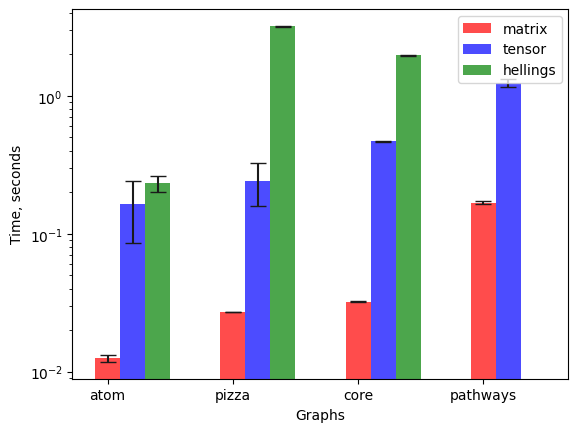

In [39]:
analyse_by_cfg(CFG_RDF, RDF_DATASET_GRAPH)

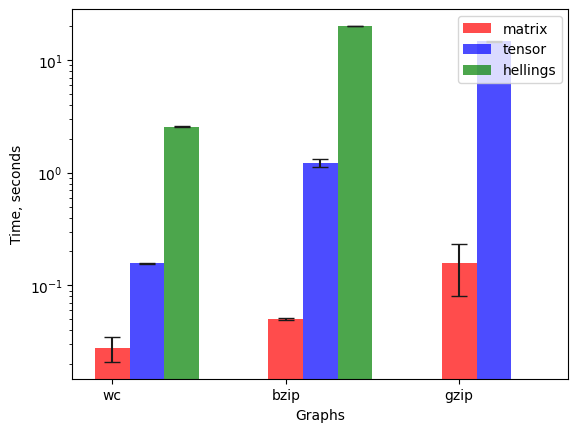

In [40]:
analyse_by_cfg(CFG_C, C_DATASET_GRAPH)

In [41]:
def analyse_by_regex(graphs):
    for num_of_type, regex in enumerate(TYPE_OF_REGEXES):
        algos_time = {"hellings": [], "matrix": [], "tensor": [], "tensor_rpq": []}
        algos_deviation = {"hellings": [], "matrix": [], "tensor": [], "tensor_rpq": []}
        for graph_name in graphs:
            graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
            graph2 = cfpq_data.add_reverse_edges(graph)
            query = Regex(generate_regexes(graph2, num_of_type))
            for alg_name in COMPARE_ALG_CFPQ_RPQ:
                times = []
                for i in range(NUMBER_OF_LAUNCHES):
                    if alg_name == "tensor_rpq":
                        start_time = time.time()
                        rpq_by_tensor(graph2, query)
                        final_time = time.time() - start_time
                        times.append(final_time)
                    else:
                        cfg = query.to_cfg()
                        start_time = time.time()
                        cfpq(graph=graph2, cfg=cfg, alg_type=alg_name)
                        final_time = time.time() - start_time
                        times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                algos_time[alg_name].append(mean_time)
                algos_deviation[alg_name].append(deviation)
        draw_diagram(graphs, algos_time, algos_deviation, COMPARE_ALG_CFPQ_RPQ, regex)

In [43]:
analyse_by_regex(RDF_DATASET_GRAPH)

KeyboardInterrupt: 